# Procesado Masivo de Datos

### Ana Pérez Hoyos, Ariadna Viera Santana, Marta Cartillo Ortiz y María Pardo Díaz.

Este proyecto consta de dos notebooks diferetes.
En este primer Notebook emplearemos *Dataframe-based-API* del modulo MlLib de pySpark. 

La base de datos empleada en este proyecto es *'Estimation of obesity levels based on eating habits and physical condition Data Set'* https://archive.ics.uci.edu/ml/datasets/Estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition+

**- Descripción del dataset:**

Este conjunto de datos contiene información de diferentes pacientes procedentes de México, Perú y Colombia, de edades entre 14 y 61 años. Los datos fueron recogidos mediante una encuesta anónima utilizando una página web, generando 17 atritubos y 2111 observaciones después de utilizar un proceso para balancear las clases (el 77% de los datos fueron generados de manera sintética utilizando las herramientas Weka y SMOTE filter). La base de datos contiene características de naturaleza tanto cuantitativa como categórica.
    
**- Atributos:**
- ***Género***: masculino o femenino
- ***Edad***: entre 14 y 61 años
- ***Altura***: float
- ***Peso***: en kg
- ***Antecedentes familiares de obesidad***: sí/no
- ***FAVC***: sí/no. Consumo frecuente de alimentos altos en calorías.
- ***FCVC***: 1, 2 o 3. Frecuencia de consumo de verduras.
- ***NCP***: 1, 2, 3. Número de comidas al día (1: entre una y 2; 2: tres; 3: más de tres).
- ***CAEC***: No, Sometimes, Frequently, Always. Consumo comida entre horas.
- ***SMOKE***: sí/no. Fumador o no fumador.
- ***CH2O***: 1, 2, 3. Consumo agua (1: menos de 1L; 2: entre 1 y 2L; 3: más de 2 L)
- ***SCC***: sí/no. Monitorización de calorías.
- ***FAF***: 0, 1, 2, 3. Frecuencia actividad física (0: nunca; 1: uno o dos días; 2: dos o cuatro días; 3: cuatro o cinco días).
- ***TUE***: 0, 1, 2. Uso de dispositivos electrónicos por ejemplo: móvil, videojuegos, televisión, ordenador... (0: entre 0-2h; 1: entre 3-5h; 2; más de 5h.
- ***CALC***:  No, Sometimes, Frequently, Always. Consumo de alcohol.
- ***MTRANS***: Automobile, Motorbike, Bike, Public Transportation, Walking. Medio de transporte
- ***NObesity***: Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II and Obesity Type III. Etiqueta asociada a la salida deseada.

ML en Spark:
https://github.com/dhirajprai/SparkML/blob/master/SparkML/logisticregression.ipynb

Scalable: https://www.codementor.io/@jadianes/spark-mllib-logistic-regression-du107neto


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:

# Installing pySpark and importing some useful packages
!pip install pyspark[sql]

from __future__ import print_function
from functools import wraps
import pyspark as spark
from pyspark import SparkConf
import time
from operator import add
import os 
from subprocess import STDOUT, check_call, check_output
import numpy as np


     |████████████████████████████████| 212.3MB 66kB/s 
     |████████████████████████████████| 204kB 19.0MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=1a987d42d398892ab511e96108923bf591d708fb4ab9cbe72a117eec8f3695ff
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


In [3]:
# Inicializamos Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").appName("obesity").config("spark.some.config.option","some-value").getOrCreate()

In [4]:
# Extraemos los datos de la base de datos
raw_data = spark.read.format("csv").option("header","true").option("inferSchema", "true").load(r"/content/drive/My Drive/PMD/ObesityDataSet_raw_and_data_sinthetic.csv")
raw_data.columns


['Gender',
 'Age',
 'Height',
 'Weight',
 'family_history_with_overweight',
 'FAVC',
 'FCVC',
 'NCP',
 'CAEC',
 'SMOKE',
 'CH2O',
 'SCC',
 'FAF',
 'TUE',
 'CALC',
 'MTRANS',
 'NObeyesdad']

In [5]:
raw_data.show(5)

+------+----+------+------+------------------------------+----+----+---+---------+-----+----+---+---+---+----------+--------------------+-------------------+
|Gender| Age|Height|Weight|family_history_with_overweight|FAVC|FCVC|NCP|     CAEC|SMOKE|CH2O|SCC|FAF|TUE|      CALC|              MTRANS|         NObeyesdad|
+------+----+------+------+------------------------------+----+----+---+---------+-----+----+---+---+---+----------+--------------------+-------------------+
|Female|21.0|  1.62|  64.0|                           yes|  no| 2.0|3.0|Sometimes|   no| 2.0| no|0.0|1.0|        no|Public_Transporta...|      Normal_Weight|
|Female|21.0|  1.52|  56.0|                           yes|  no| 3.0|3.0|Sometimes|  yes| 3.0|yes|3.0|0.0| Sometimes|Public_Transporta...|      Normal_Weight|
|  Male|23.0|   1.8|  77.0|                           yes|  no| 2.0|3.0|Sometimes|   no| 2.0| no|2.0|1.0|Frequently|Public_Transporta...|      Normal_Weight|
|  Male|27.0|   1.8|  87.0|                         

In [6]:
#Extraemos los estadísticos principales de las características cuantitativas
raw_data.describe().select('Age', 'Height', 'Weight','FCVC').show()

+-----------------+-------------------+------------------+------------------+
|              Age|             Height|            Weight|              FCVC|
+-----------------+-------------------+------------------+------------------+
|             2111|               2111|              2111|              2111|
|24.31259990857412| 1.7016773533870178| 86.58605812648037|2.4190430615821916|
|6.345968273732226|0.09330481986792012|26.191171745204706|0.5339265785032998|
|             14.0|               1.45|              39.0|               1.0|
|             61.0|               1.98|             173.0|               3.0|
+-----------------+-------------------+------------------+------------------+



In [7]:
print('Las dimensiones de la base de datos son: ')
print((raw_data.count(), len(raw_data.columns)))

Las dimensiones de la base de datos son: 
(2111, 17)


In [8]:
#Vemos tipo de datos que contienen las variabes
raw_data.printSchema()

root
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Height: double (nullable = true)
 |-- Weight: double (nullable = true)
 |-- family_history_with_overweight: string (nullable = true)
 |-- FAVC: string (nullable = true)
 |-- FCVC: double (nullable = true)
 |-- NCP: double (nullable = true)
 |-- CAEC: string (nullable = true)
 |-- SMOKE: string (nullable = true)
 |-- CH2O: double (nullable = true)
 |-- SCC: string (nullable = true)
 |-- FAF: double (nullable = true)
 |-- TUE: double (nullable = true)
 |-- CALC: string (nullable = true)
 |-- MTRANS: string (nullable = true)
 |-- NObeyesdad: string (nullable = true)



In [9]:
#Valores únicos de las caractarísticas:
cols=raw_data.columns
for i in cols:
  print(i,":",raw_data.select(i).distinct().count())

Gender : 2
Age : 1402
Height : 1574
Weight : 1525
family_history_with_overweight : 2
FAVC : 2
FCVC : 810
NCP : 635
CAEC : 4
SMOKE : 2
CH2O : 1268
SCC : 2
FAF : 1190
TUE : 1129
CALC : 4
MTRANS : 5
NObeyesdad : 7


In [10]:
#Comprobamos que las clases están balanceadas
raw_data.groupBy(['NObeyesdad']).count().show()

+-------------------+-----+
|         NObeyesdad|count|
+-------------------+-----+
|   Obesity_Type_III|  324|
| Overweight_Level_I|  290|
|    Obesity_Type_II|  297|
|Insufficient_Weight|  272|
|Overweight_Level_II|  290|
|      Normal_Weight|  287|
|     Obesity_Type_I|  351|
+-------------------+-----+



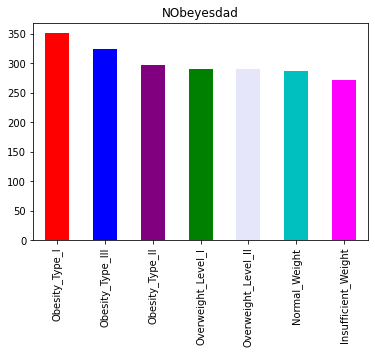

In [11]:
data_pd=raw_data.select("*").toPandas()
#data_pd
data_pd['NObeyesdad'].value_counts().plot.bar(title="NObeyesdad", color=['red', 'blue', 'purple', 'green', 'lavender', 'c', 'magenta'])

En el histograma se muestran el número de registros pertenecientes a cada clase, podemos ver que las clases están balanceadas.

Como en muchas de las variables categóricas como el consumo de agua diario (CH2O) se han estimado los valores de las muestras creadas sinteticamente mediante distribuciones uniformes, debemos redondear estos valores para que tengan algún tipo de sentido. Por tanto, lo primero de todo en este apartado de pre-procesado sería redondear las variables categóricas generadas de manera sintética, a números enteros. Esta transformación es necesaria para que tengan la misma apariencia y estructura que los datos recogidos originales

In [12]:
from pyspark.sql.functions import round, col
from pyspark.sql.functions import *
 
# 1 Select the column
CH2O_r = raw_data.select("*", round(col('CH2O')))
FAF_r=raw_data.select("*", round(col('FAF')))
TUE_r=raw_data.select("*", round(col('TUE')))
FCVC_r=raw_data.select("*", round(col('FCVC')))
NCP_r=raw_data.select("*", round(col('NCP')))
 
# 2 Apply the transformation and add it to the DataFrame
raw_data = raw_data.withColumn("CH2O_r",round(col('CH2O')))
raw_data = raw_data.withColumn("FAF_r",round(col('FAF')))
raw_data = raw_data.withColumn("TUE_r",round(col('TUE')))
raw_data = raw_data.withColumn("FCVC_r",round(col('FCVC')))
raw_data = raw_data.withColumn("NCP_r",round(col('NCP')))
 
#raw_data.tail(5)

En este paso además, convertiremos los valores de NCP=4 en NCP=3, ya que al redondear los datos que fueron generados de forma sintética, ha aparecido un valor (4) que no existía en los valores de la característica en su origen

In [13]:
raw_data.select("NCP_r").distinct().show()

+-----+
|NCP_r|
+-----+
|  1.0|
|  4.0|
|  3.0|
|  2.0|
+-----+



In [14]:
raw_data = raw_data.withColumn('NCP_r', regexp_replace('NCP_r', '4', '3'))

from pyspark.sql.types import DoubleType
raw_data= raw_data.withColumn('NCP_r', raw_data["NCP_r"].cast(DoubleType()))
raw_data.select("NCP_r").distinct().show()

+-----+
|NCP_r|
+-----+
|  1.0|
|  3.0|
|  2.0|
+-----+



In [15]:
raw_data.printSchema()

root
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Height: double (nullable = true)
 |-- Weight: double (nullable = true)
 |-- family_history_with_overweight: string (nullable = true)
 |-- FAVC: string (nullable = true)
 |-- FCVC: double (nullable = true)
 |-- NCP: double (nullable = true)
 |-- CAEC: string (nullable = true)
 |-- SMOKE: string (nullable = true)
 |-- CH2O: double (nullable = true)
 |-- SCC: string (nullable = true)
 |-- FAF: double (nullable = true)
 |-- TUE: double (nullable = true)
 |-- CALC: string (nullable = true)
 |-- MTRANS: string (nullable = true)
 |-- NObeyesdad: string (nullable = true)
 |-- CH2O_r: double (nullable = true)
 |-- FAF_r: double (nullable = true)
 |-- TUE_r: double (nullable = true)
 |-- FCVC_r: double (nullable = true)
 |-- NCP_r: double (nullable = true)



In [16]:
#Vemos que no tiene missing values
from pyspark.sql.functions import col,sum
raw_data.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in raw_data.columns)).show()

+------+---+------+------+------------------------------+----+----+---+----+-----+----+---+---+---+----+------+----------+------+-----+-----+------+-----+
|Gender|Age|Height|Weight|family_history_with_overweight|FAVC|FCVC|NCP|CAEC|SMOKE|CH2O|SCC|FAF|TUE|CALC|MTRANS|NObeyesdad|CH2O_r|FAF_r|TUE_r|FCVC_r|NCP_r|
+------+---+------+------+------------------------------+----+----+---+----+-----+----+---+---+---+----+------+----------+------+-----+-----+------+-----+
|     0|  0|     0|     0|                             0|   0|   0|  0|   0|    0|   0|  0|  0|  0|   0|     0|         0|     0|    0|    0|     0|    0|
+------+---+------+------+------------------------------+----+----+---+----+-----+----+---+---+---+----+------+----------+------+-----+-----+------+-----+



Vamos a eliminar las variables 'Height' (altura) y 'Weight' (peso), debido a su alta correlación con la salida. Esta correlación tan directa viene dada porque son las dos características que definen el grado de obesidad mediante la fórmula:

𝑀𝑎𝑠𝑠𝑏𝑜𝑑𝑦𝑖𝑛𝑑𝑒𝑥=𝑤𝑒𝑖𝑔ℎ𝑡/(ℎ𝑒𝑖𝑔ℎ𝑡∗ℎ𝑒𝑖𝑔ℎ𝑡)
 
Después de calcular el Mass body index (BMI) o índice de masa corporal en español, se asigna una categoría dependiendo del intervalo en el que se encuentre dicho valor.

Underweight: BMI < 18.5

Normal: 18.5 < BMI < 24.9

Overweight: 25.0 < BMI < 29.9

Obesity I: 30.0 < BMI < 34.9

Obesity II: 35.0 < BMI < 39.9

Obesity III: BMI > 40

Por lo dicho, solo tiene sentido comprobar los valores anómalos en la variable de Age. Y al ser nuestra base de datos una encuesta con diferentes y muy variados valores, no consideramos que sea necesario imputar los valores de edad fuera del intervalos de z score.
En añadido, usaremos las variables que hemos redondeado.

In [17]:

from pyspark.ml.feature import StringIndexer
stringIndexer = StringIndexer(inputCol="NObeyesdad", outputCol="newNObeyesdad")
model = stringIndexer.fit(raw_data)
raw_data = model.transform(raw_data)


In [18]:
select_variables = raw_data.select('Age', 'FCVC_r', 'NCP_r', 'CH2O_r', 'FAF_r', 'TUE_r', 'Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'newNObeyesdad' )

In [19]:
#Obesity_Type_I=0
#Obesity_Type_III=1
#Obesity_Type_II=2
#Overweight_Level_I=3
#Overweight_Level_II=4
#Normal_Weight=5
#Insufficient_Weight=6



In [20]:
#Separamos las variables numericas de las categóricas, ya que únicamente se emplea el one hot encoding en las variables categóricas

catCols = [x for (x, dataType) in select_variables.dtypes if dataType == 'string']
numCols = [x for (x, dataType) in select_variables.dtypes if ((dataType == 'double') & (x != "isFraud")) ]

print(catCols)
print(numCols)

#catCols=raw_data.select('Gender')

['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
['Age', 'FCVC_r', 'NCP_r', 'CH2O_r', 'FAF_r', 'TUE_r', 'newNObeyesdad']


Observamos algunas de las variables categóricas

## One hot encoding

In [21]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

In [22]:
#Aplicamos one hot encoding para pasar modificar variables categóricas 

from pyspark.ml.feature import (OneHotEncoder, StringIndexer)

In [23]:
#StringIndexer(inputCol="Gender", outputCol="Gender_encoded")

string_indexer = [ 
      StringIndexer(inputCol=x, outputCol=x + "_StringIndexer", handleInvalid="skip")
      for x in catCols]

In [24]:
one_hot_encoder = [
          OneHotEncoder(
              inputCols=[f"{x}_StringIndexer" for x in catCols],
              outputCols=[f"{x}_OneHotEncoder" for x in catCols],
          )
]

In [25]:
#Vector assembling combina los valores de inputCols en un solo vector

from pyspark.ml.feature import VectorAssembler

In [26]:
assemblerInput = [x for x in numCols]
assemblerInput += [f"{x}_OneHotEncoder" for x in catCols]

In [27]:
assemblerInput

['Age',
 'FCVC_r',
 'NCP_r',
 'CH2O_r',
 'FAF_r',
 'TUE_r',
 'newNObeyesdad',
 'Gender_OneHotEncoder',
 'family_history_with_overweight_OneHotEncoder',
 'FAVC_OneHotEncoder',
 'CAEC_OneHotEncoder',
 'SMOKE_OneHotEncoder',
 'SCC_OneHotEncoder',
 'CALC_OneHotEncoder',
 'MTRANS_OneHotEncoder']

In [28]:
vector_assembler = VectorAssembler(
    inputCols=assemblerInput, outputCol='VectorAssembler_features'
)

In [29]:
stages=[]
stages += string_indexer
stages += one_hot_encoder
stages += [vector_assembler]

In [30]:
from pyspark.ml import Pipeline

pipeline = Pipeline().setStages(stages)

model = pipeline.fit(select_variables)

new_data = model.transform(select_variables)

In [31]:
new_data.select('Age', 'FCVC_r', 'NCP_r', 'CH2O_r', 'FAF_r', 'TUE_r', 
                'Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'newNObeyesdad',
                'VectorAssembler_features').show(truncate=False)

+----+------+-----+------+-----+-----+------+------------------------------+----+----------+-----+---+----------+---------------------+-------------+--------------------------------------------------------------------------------------------+
|Age |FCVC_r|NCP_r|CH2O_r|FAF_r|TUE_r|Gender|family_history_with_overweight|FAVC|CAEC      |SMOKE|SCC|CALC      |MTRANS               |newNObeyesdad|VectorAssembler_features                                                                    |
+----+------+-----+------+-----+-----+------+------------------------------+----+----------+-----+---+----------+---------------------+-------------+--------------------------------------------------------------------------------------------+
|21.0|2.0   |3.0  |2.0   |0.0  |1.0  |Female|yes                           |no  |Sometimes |no   |no |no        |Public_Transportation|5.0          |(22,[0,1,2,3,5,6,8,10,13,14,16,18],[21.0,2.0,3.0,2.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0])      |
|21.0|3.0   |3.0  |3.0   |3.

In [32]:
new_data.show(5)

+----+------+-----+------+-----+-----+------+------------------------------+----+---------+-----+---+----------+--------------------+-------------+--------------------+--------------------------------------------+------------------+------------------+-------------------+-----------------+------------------+--------------------+--------------------+------------------+------------------+-------------------+--------------------+-----------------+--------------------------------------------+------------------+------------------------+
| Age|FCVC_r|NCP_r|CH2O_r|FAF_r|TUE_r|Gender|family_history_with_overweight|FAVC|     CAEC|SMOKE|SCC|      CALC|              MTRANS|newNObeyesdad|Gender_StringIndexer|family_history_with_overweight_StringIndexer|FAVC_StringIndexer|CAEC_StringIndexer|SMOKE_StringIndexer|SCC_StringIndexer|CALC_StringIndexer|MTRANS_StringIndexer|Gender_OneHotEncoder|FAVC_OneHotEncoder|CAEC_OneHotEncoder|SMOKE_OneHotEncoder|MTRANS_OneHotEncoder|SCC_OneHotEncoder|family_history_w

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Divimos los datos en Train y Test para entrenar los algoritmos de machine learning

In [34]:
# Split the data
(train_data, test_data) = new_data.randomSplit([0.8,0.2], seed =2020)
print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 1687
Test Dataset Count: 424


In [35]:
class_temp = test_data.select("newNObeyesdad").groupBy("newNObeyesdad")\
                        .count().sort('count', ascending=True).toPandas()
class_temp = class_temp["newNObeyesdad"].values.tolist()


# Random Forest

In [36]:
%%time
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol='newNObeyesdad', 
                            featuresCol='VectorAssembler_features',
                            maxDepth=5,
                            seed=122)
model = rf.fit(train_data)
rf_predictions = model.transform(test_data)
print('Tiempo que tarda en entrenar el modelo:')

Tiempo que tarda en entrenar el modelo:
CPU times: user 72.5 ms, sys: 7.17 ms, total: 79.7 ms
Wall time: 5.48 s


In [37]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'newNObeyesdad', metricName = 'accuracy')
print('Random Forest classifier Accuracy:', multi_evaluator.evaluate(rf_predictions))
print('')

Random Forest classifier Accuracy: 0.8985849056603774



Confusion matrix, without normalization
[[30  0  4  3  1  1  0]
 [ 1 51  0  0  0  0  0]
 [ 0  0 59  1  0  0  0]
 [10  0  1 46  4  1  0]
 [ 4  0  4  5 53  0  0]
 [ 0  0  0  0  0 69  0]
 [ 0  0  0  0  0  3 73]]


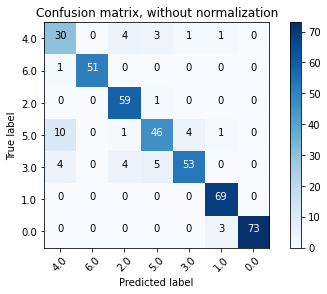

In [38]:
from sklearn.metrics import confusion_matrix
y_true = test_data.select("newNObeyesdad")
y_true = y_true.toPandas()

y_pred = rf_predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_temp)
#cnf_matrix

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp,title='Confusion matrix, without normalization')
plt.show()

'Insuficiente'--> 6

'Normal' --> 5

'SobrePesoI' --> 3

'SobrePeso_II' --> 4

'Obesidad_I'--> 0

'Obesidad_III'--> 1

'Obesidad_II'--> 2


In [39]:
y_truee= y_true.to_numpy()
y_predd= y_pred.to_numpy()

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_truee, y_predd,target_names=['Obesidad_I','Obesidad_III','Obesidad_II','SobrePesoI','SobrePeso_II','Normal','Insuficiente']))


              precision    recall  f1-score   support

  Obesidad_I       1.00      0.96      0.98        76
Obesidad_III       0.93      1.00      0.97        69
 Obesidad_II       0.87      0.98      0.92        60
  SobrePesoI       0.91      0.80      0.85        66
SobrePeso_II       0.67      0.77      0.71        39
      Normal       0.84      0.74      0.79        62
Insuficiente       1.00      0.98      0.99        52

    accuracy                           0.90       424
   macro avg       0.89      0.89      0.89       424
weighted avg       0.90      0.90      0.90       424



## Resultados Random Forest

Este modelo nos proporciona una alta Tasa de Acierto (Accuracy: 0.8985849056603774). 
A partir de la matriz de confusión y de la Sensibilidad y Especificidad haremos un análisis de la clasificación:
- En primer lugar, podemos ver que la Obesidad_Tipo_III, la obesidad de mayor grado, obtiene una sensibilidad de 1.0, esto quiere decir que todos los pacientes de este grupo fueron bien clasificados. Los otros dos tipos de obesidad también han obtenido métricas buenas.
***Conclusión*** : este método parece que consigue predecir con bastante exactitud a partir de los hábitos de los encuestados cual es su tipo de obesidad, por que podemos inferir que los hábitos influyen en el grado de obesidad que se padece.
- En segundo lugar, analizamos la clasificación de Peso_Insuficiente. En este caso solamente uno de estos pacientes fue asignado a otra clase, concretamente Sobre_Peso_II, pero ningún paciente fue asignado a este grupo sin pertenecer a él, por lo que la especificidad es de 1.0.
- Por último, las peores méticas la obtenemos con los grupos de Normal, Sobrepeso_I y Sobrepeso_II que a pesar de realizar una clasificación notablemente buena, equivocan, sobre todo entre estos mismos grupos a algunos pacientes.

## Tiempo empleado Random Forest:

Tiempo que tarda en entrenar el modelo:

CPU times: user 67.6 ms

sys: 8.39 ms

***total: 76 ms***

**Wall time: 5.68 s**


# Árbol de decisión

In [41]:
#Diseñamos el modelo de árbol para estimar los datos
%%time
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'VectorAssembler_features', labelCol = 'newNObeyesdad', maxDepth = 4,seed=12)
dtModel = dt.fit(train_data)
dt_predictions = dtModel.transform(test_data)
print('Tiempo que tarda en entrenar el modelo:')

Tiempo que tarda en entrenar el modelo:
CPU times: user 45.2 ms, sys: 5.25 ms, total: 50.4 ms
Wall time: 2.61 s


In [42]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'newNObeyesdad', metricName = 'accuracy')
print('Decision Tree Accuracy:', multi_evaluator.evaluate(dt_predictions))
print('')

Decision Tree Accuracy: 0.7216981132075472



Imprimimos el árbol generado

In [43]:
pipeline = Pipeline(stages=[vector_assembler, dtModel])
model = pipeline.fit(train_data)
vectAssembler = model.stages[0]
dtModel = model.stages[1]
print("Nodos: " + str(dtModel.numNodes))
print("Profundidad: "+ str(dtModel.depth)) # summary only
print(dtModel.toDebugString)

Nodos: 9
Profundidad: 4
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_02a9525bb416, depth=4, numNodes=9, numClasses=7, numFeatures=22
  If (feature 6 in {0.0})
   Predict: 0.0
  Else (feature 6 not in {0.0})
   If (feature 6 in {1.0})
    Predict: 1.0
   Else (feature 6 not in {1.0})
    If (feature 6 in {2.0})
     Predict: 2.0
    Else (feature 6 not in {2.0})
     If (feature 6 in {3.0,4.0})
      Predict: 4.0
     Else (feature 6 not in {3.0,4.0})
      Predict: 5.0



In [44]:
from sklearn.metrics import confusion_matrix
y_true = test_data.select("newNObeyesdad")
y_true = y_true.toPandas()

y_pred = dt_predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_temp)
#cnf_matrix

Confusion matrix, without normalization
[[39  0  0  0  0  0  0]
 [ 0  0  0 52  0  0  0]
 [ 0  0 60  0  0  0  0]
 [ 0  0  0 62  0  0  0]
 [66  0  0  0  0  0  0]
 [ 0  0  0  0  0 69  0]
 [ 0  0  0  0  0  0 76]]


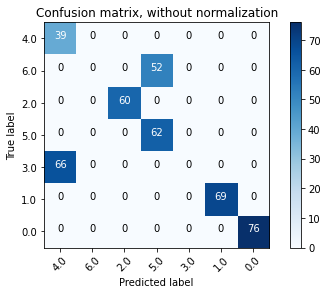

In [45]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp,
                      title='Confusion matrix, without normalization')
plt.show()

'Insuficiente'--> 6

'Normal' --> 5

'SobrePesoI' --> 3

'SobrePeso_II' --> 4

'Obesidad_I'--> 0

'Obesidad_III'--> 1

'Obesidad_II'--> 2


In [46]:
y_truee= y_true.to_numpy()
y_predd= y_pred.to_numpy()

In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_truee, y_predd,target_names=['Obesidad_I','Obesidad_III','Obesidad_II','SobrePesoI','SobrePeso_II','Normal','Insuficiente']))


              precision    recall  f1-score   support

  Obesidad_I       1.00      1.00      1.00        76
Obesidad_III       1.00      1.00      1.00        69
 Obesidad_II       1.00      1.00      1.00        60
  SobrePesoI       0.00      0.00      0.00        66
SobrePeso_II       0.37      1.00      0.54        39
      Normal       0.54      1.00      0.70        62
Insuficiente       0.00      0.00      0.00        52

    accuracy                           0.72       424
   macro avg       0.56      0.71      0.61       424
weighted avg       0.60      0.72      0.64       424



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Resultados Árbol de Decisión:
Este modelo nos proporciona una Tasa de Acierto no muy alta (Accuracy: 0.7216981132075472). 
A partir de la matriz de confusión y de la Sensibilidad y Especificidad haremos un análisis de la clasificación:
- En este caso volvemos a observar que las clases que mejor clasifica son los tres grados de obesidad, obteniendo en los tres la máxima precisión, Sensibilidad y Especificidad posibles (1.0)
****Conclusión:** la conclusión anterior se refuerza, los hábitos de las personas guardan una gran relación con el grado de obesidad de las mismas.
- En cambio, para el resto de grupos vemos que el modelo simplemente clasifica a los restantes a todos en el mismo grupo (SobrePeso_II), es decir este modelo no consigue establecer diferencias entre ellos y los agrupa a todos ( SobrePesoI, SobrePeso_II, Normal, Insuficienteen) en el mismo. De ahí que la precisión comjunta del modelo sea tan baja.

## Tiempo empleado Árbol de Decisión:

Tiempo que tarda en entrenar el modelo:

CPU times: user 46.2 ms

sys: 6.36 ms

***total: 52.5 ms***


**Wall time: 2.62 s**

# Regresión Logística

In [48]:
%%time
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'VectorAssembler_features', labelCol = 'newNObeyesdad', maxIter=10)
lrModel = lr.fit(train_data)
lr_predictions = lrModel.transform(test_data)
print('Tiempo que tarda en entrenar el modelo:')

Tiempo que tarda en entrenar el modelo:
CPU times: user 55.9 ms, sys: 3.62 ms, total: 59.5 ms
Wall time: 3.72 s


In [49]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'newNObeyesdad', metricName = 'accuracy')
print('Logistic Regression Accuracy:', multi_evaluator.evaluate(lr_predictions))
print('')

Logistic Regression Accuracy: 0.6839622641509434



In [50]:
from sklearn.metrics import confusion_matrix
y_true = test_data.select("newNObeyesdad")
y_true = y_true.toPandas()

y_pred = lr_predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_temp)
#cnf_matrix

Confusion matrix, without normalization
[[22  0  6  2  9  0  0]
 [ 6 43  0  3  0  0  0]
 [ 1  0 45  1  5  0  8]
 [ 8 26  0 20  8  0  0]
 [16  1  9  7 31  0  2]
 [ 0  0  0  0  0 69  0]
 [ 0  0  8  1  1  6 60]]


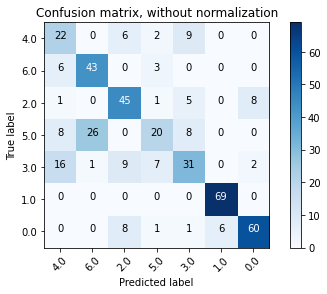

In [51]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp, title='Confusion matrix, without normalization')
plt.show()

In [52]:
y_truee= y_true.to_numpy()
y_predd= y_pred.to_numpy()

In [53]:

    
from sklearn.metrics import classification_report
print(classification_report(y_truee, y_predd,target_names=['Obesidad_I','Obesidad_III','Obesidad_II','SobrePesoI','SobrePeso_II','Normal','Insuficiente']))


              precision    recall  f1-score   support

  Obesidad_I       0.86      0.79      0.82        76
Obesidad_III       0.92      1.00      0.96        69
 Obesidad_II       0.66      0.75      0.70        60
  SobrePesoI       0.57      0.47      0.52        66
SobrePeso_II       0.42      0.56      0.48        39
      Normal       0.59      0.32      0.42        62
Insuficiente       0.61      0.83      0.70        52

    accuracy                           0.68       424
   macro avg       0.66      0.67      0.66       424
weighted avg       0.69      0.68      0.67       424



## Resultados Regresión Logística

Este modelo nos proporciona una Tasa de Acierto aceptable (Accuracy: 0.6839622641509434). A partir de la matriz de confusión y de la Sensibilidad y Especificidad haremos un análisis de la clasificación:
- Volvemos a observar mejores métricas en los grupos de Obesidad, pero en menor medida que en casos anteriores, por lo que este no sería concluyente por si mismo.
- El resto de grupos obtienen puntuaciones insuficientes.

## Tiempo empleado en Regresión Logística:

Tiempo que tarda en entrenar el modelo:

CPU times: user 65.5 ms

sys: 3.37 ms

***total: 68.8 ms***


**Wall time: 4.12 s**

# Naive Bayes

In [54]:
%%time
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(featuresCol = 'VectorAssembler_features', labelCol = 'newNObeyesdad', smoothing=1)
model = nb.fit(train_data)
predictions_nb = model.transform(test_data)
print('Tiempo que tarda en entrenar el modelo:')

Tiempo que tarda en entrenar el modelo:
CPU times: user 40.6 ms, sys: 7.67 ms, total: 48.3 ms
Wall time: 3.82 s


In [55]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'newNObeyesdad', metricName = 'accuracy')
print('Naive Bayes Accuracy:', multi_evaluator.evaluate(predictions_nb))
print('')

Naive Bayes Accuracy: 0.7240566037735849



In [56]:
from sklearn.metrics import confusion_matrix
y_true = test_data.select("newNObeyesdad")
y_true = y_true.toPandas()

y_pred = predictions_nb.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_temp)
#cnf_matrix

Confusion matrix, without normalization
[[22  0  6  1 10  0  0]
 [ 1 49  0  2  0  0  0]
 [ 7  0 48  1  4  0  0]
 [11 23  0 21  7  0  0]
 [14  1 14  6 31  0  0]
 [ 0  0  0  0  0 69  0]
 [ 0  0  0  0  0  9 67]]


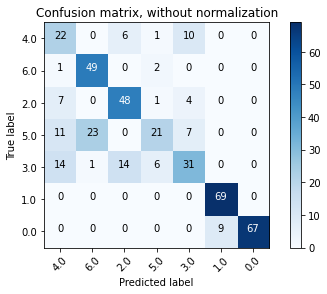

In [57]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp,
                      title='Confusion matrix, without normalization')
plt.show()

In [58]:
y_truee= y_true.to_numpy()
y_predd= y_pred.to_numpy()

In [59]:

    
from sklearn.metrics import classification_report
print(classification_report(y_truee, y_predd,target_names=['Obesidad_I','Obesidad_III','Obesidad_II','SobrePesoI','SobrePeso_II','Normal','Insuficiente']))


              precision    recall  f1-score   support

  Obesidad_I       1.00      0.88      0.94        76
Obesidad_III       0.88      1.00      0.94        69
 Obesidad_II       0.71      0.80      0.75        60
  SobrePesoI       0.60      0.47      0.53        66
SobrePeso_II       0.40      0.56      0.47        39
      Normal       0.68      0.34      0.45        62
Insuficiente       0.67      0.94      0.78        52

    accuracy                           0.72       424
   macro avg       0.71      0.71      0.69       424
weighted avg       0.73      0.72      0.71       424



# Resultados Naive Bayes

Este modelo nos proporcionan una Tasa de Acierto aceptable (Accuracy: 0.7241). A partir de la matriz de confusión y de la Sensibilidad y Especificidad haremos un análisis de la clasificación:


*   Volvemos a observar mejores métricas en los grupos de Obesidad, pero en menor medida que en casos anteriores, por lo que este no sería concluyente por si mismo.

*   El resto de grupos obtienen puntuaciones insuficientes.




## Tiempo empleado en Naive Bayes:

Tiempo que tarda en entrenar el modelo:

CPU times: user 35.8 ms

sys: 2.71 ms

***total: 38.5 ms***


**Wall time: 3.27 s**